In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Load your CSV file
df = pd.read_csv('sentiment_results.csv')

# Extract the positive_prob column
sequence = df['positive_prob'].values.astype(np.float32)

# Define window size
window_size = 5
X, y = [], []
for i in range(len(sequence) - window_size):
    X.append(sequence[i:i+window_size])
    y.append(sequence[i+window_size])

X = np.array(X)
y = np.array(y)

# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).unsqueeze(-1)  # shape: (samples, window_size, 1)
        self.y = torch.from_numpy(y).unsqueeze(-1)  # shape: (samples, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SentimentDataset(X, y)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [2]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(SentimentRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Take the output from the last time step
        out = self.fc(out)
        return out

model = SentimentRNN()

In [3]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


Epoch 1/20, Loss: 0.5013
Epoch 2/20, Loss: 0.2465
Epoch 3/20, Loss: 0.0111
Epoch 4/20, Loss: 0.0087
Epoch 5/20, Loss: 0.0409
Epoch 6/20, Loss: 0.0282
Epoch 7/20, Loss: 0.0099
Epoch 8/20, Loss: 0.0904
Epoch 9/20, Loss: 0.0746
Epoch 10/20, Loss: 0.0226
Epoch 11/20, Loss: 0.0185
Epoch 12/20, Loss: 0.4940
Epoch 13/20, Loss: 0.0362
Epoch 14/20, Loss: 0.0168
Epoch 15/20, Loss: 0.1642
Epoch 16/20, Loss: 0.0363
Epoch 17/20, Loss: 0.0029
Epoch 18/20, Loss: 0.0252
Epoch 19/20, Loss: 0.0196
Epoch 20/20, Loss: 0.0788


In [4]:
# Take the last 'window_size' values from your sequence
last_seq = torch.from_numpy(sequence[-window_size:]).unsqueeze(0).unsqueeze(-1)  # shape: (1, window_size, 1)
model.eval()
with torch.no_grad():
    predicted_next = model(last_seq)
print('Predicted next positive_prob:', predicted_next.item())


Predicted next positive_prob: 0.8586434125900269


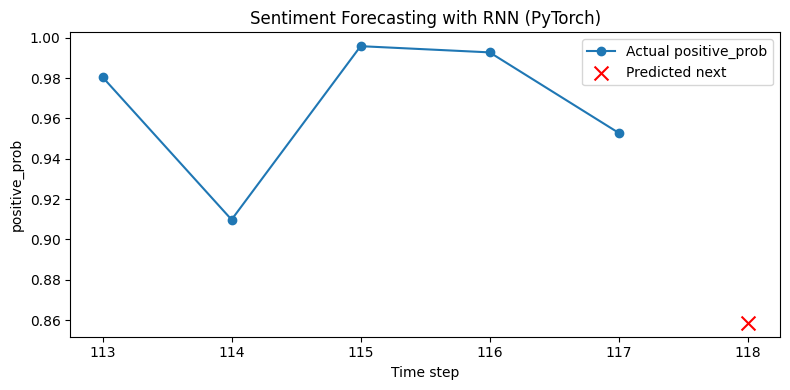

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plot the last window_size values
plt.figure(figsize=(8, 4))
plt.plot(range(len(sequence) - window_size, len(sequence)), 
         sequence[-window_size:], 
         marker='o', label='Actual positive_prob')

# Plot the predicted next value
plt.scatter(len(sequence), predicted_next, color='red', marker='x', s=100, label='Predicted next')

plt.xlabel('Time step')
plt.ylabel('positive_prob')
plt.title('Sentiment Forecasting with RNN (PyTorch)')
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
import pandas
